# Discrete hedging experiment for a European Call option under the Heston model

> TODO: Add a description to the experiment

> Under the Heston but we are using the Black-Scholes delta for hedging

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

from jax import vmap, grad, jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.experimental.bs_iv import IV_brent
import py_vollib_vectorized

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.04
mean = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

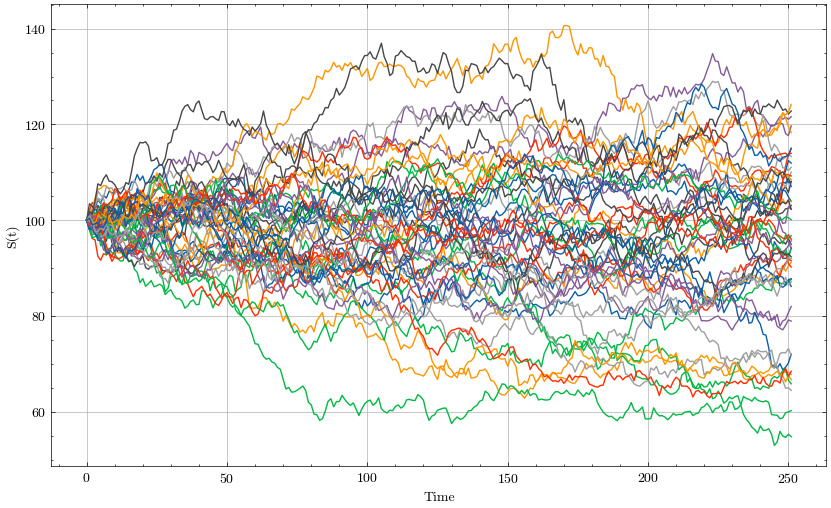

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :50])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [7]:
discount_rate = 0.0
dividends = 0.0

## Hedging experiment without transaction costs

In [8]:
ticksize = 0.00
K = 100
maturity = 1.0
N = 252
n_sim = 100

v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_delta_call = vmap(v_fourier_delta_call, in_axes=(None, None, None, 0, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_inv_call = vmap(v_fourier_inv_call, in_axes=(None, None, None, 0, None, None, None, None, None))

In [9]:
def heston_vega(s0, K, T, v, mu, theta, sigma, kappa, rho):
    return grad(fourier_inv_call, argnums=3)(s0, K, T, v, mu, theta, sigma, kappa, rho)

_v_heston_vega = vmap(heston_vega, in_axes=(0, None, None, None, None, None, None, None, None))
v_heston_vega = vmap(_v_heston_vega, in_axes=(None, None, None, 0, None, None, None, None, None))

In [124]:
def get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    deltas = [v_v_fourier_delta_call(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    deltas_ = [v_v_fourier_delta_call(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(deltas + deltas_)

def get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    vegas = [v_heston_vega(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    vegas_ = [v_heston_vega(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(vegas + vegas_)

def get_heston_hedging_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    vegas = get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)
    deltas = get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)

    return deltas + (rho * sigma / stock_paths) * vegas


In [11]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [125]:
def hedge_experiment_loop(stock_paths, var_process, K, mu, sigma, maturity, N, ticksize=0.00):
    dt = maturity / N
    deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, mu, theta, sigma, kappa, rho, N)
    cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], mu, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0]]
    vs = [cs[0]]

    for i in range(1, N):
        ddelta = deltas[i] - deltas[i - 1]
        transaction_costs = get_transaction_costs(ticksize, ddelta)

        vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
        b.append(vs[i] - (deltas[i] + transaction_costs) * stock_paths[i])
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

    return jnp.mean(hedge_error[-1]) / jnp.asarray(cs)[0, 0], jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]

### Experiments

In [13]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [14]:
def update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike'].append(K)
    results['Sigma'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

In [15]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.004384106025099754
The normalized std of the hedge error is: 0.10692881792783737


Weekly rebalancing $n=52$

In [16]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [17]:
var_process.shape

(52, 100)

In [18]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.0005655665881931782
The normalized std of the hedge error is: 0.15486975014209747


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [19]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [20]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.0012939957669004798
The normalized std of the hedge error is: 0.014856246300041676


Weekly rebalancing $n=52$

In [21]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [22]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.0069017112255096436
The normalized std of the hedge error is: 0.03436056524515152


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [23]:
K = 90
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [24]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.004340775310993195
The normalized std of the hedge error is: 0.041264913976192474


Weekly rebalancing $n=52$

In [25]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [26]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.002333794254809618
The normalized std of the hedge error is: 0.06414748728275299


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [27]:
K = 110
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [28]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.004449148196727037
The normalized std of the hedge error is: 0.18242910504341125


Weekly rebalancing $n=52$

In [29]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [30]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.013897181488573551
The normalized std of the hedge error is: 0.2580913305282593


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [31]:
K = 120
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [32]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.0053415363654494286
The normalized std of the hedge error is: 0.33713388442993164


Weekly rebalancing $n=52$

In [33]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [34]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.009566203691065311
The normalized std of the hedge error is: 0.5539723038673401


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [126]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [36]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.00887870229780674
The normalized std of the hedge error is: 0.19440411031246185


Weekly rebalancing $n=104$

In [37]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [38]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.009727594442665577
The normalized std of the hedge error is: 0.22351494431495667


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [130]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [131]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=26$

In [41]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [42]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [43]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [44]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [45]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [46]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [47]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,0.004384106,0.10692882
1,100,0.1,1.0,52,0.0005655666,0.15486975
2,80,0.1,1.0,252,0.0012939958,0.014856246
3,80,0.1,1.0,52,-0.006901711,0.034360565
4,90,0.1,1.0,252,0.0043407753,0.041264914
5,90,0.1,1.0,52,0.0023337943,0.06414749
6,110,0.1,1.0,252,-0.004449148,0.1824291
7,110,0.1,1.0,52,-0.0138971815,0.25809133
8,120,0.1,1.0,252,0.0053415364,0.33713388
9,120,0.1,1.0,52,-0.009566204,0.5539723


In [48]:
res_df.to_csv('./results/heston_delta_zero.csv')

### Hedging experiments with low transcation costs

### Experiments

In [49]:
ticksize = 0.01
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [50]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [51]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.6348021030426025
The normalized std of the hedge error is: 0.28152963519096375


Weekly rebalancing $n=52$

In [52]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [53]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.28231728076934814
The normalized std of the hedge error is: 0.15229392051696777


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [54]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [55]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.12442024797201157
The normalized std of the hedge error is: 0.08486099541187286


Weekly rebalancing $n=52$

In [56]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [57]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.05931755527853966
The normalized std of the hedge error is: 0.057210665196180344


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [58]:
K = 90
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [59]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.27905046939849854
The normalized std of the hedge error is: 0.14993612468242645


Weekly rebalancing $n=52$

In [60]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [61]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.1486475020647049
The normalized std of the hedge error is: 0.0935681089758873


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [62]:
K = 110
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [63]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -1.177548885345459
The normalized std of the hedge error is: 0.6180097460746765


Weekly rebalancing $n=52$

In [64]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [65]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.5268413424491882
The normalized std of the hedge error is: 0.3418228328227997


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [66]:
K = 120
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [67]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -1.8496146202087402
The normalized std of the hedge error is: 1.3474477529525757


Weekly rebalancing $n=52$

In [68]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [69]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.8742526173591614
The normalized std of the hedge error is: 0.8478839993476868


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [70]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [71]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.591599702835083
The normalized std of the hedge error is: 0.20015151798725128


Weekly rebalancing $n=104$

In [72]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [73]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.2587975263595581
The normalized std of the hedge error is: 0.2267216444015503


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [74]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [75]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [76]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [77]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [78]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [79]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [80]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [81]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [82]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.6348021,0.28152964
1,100,0.1,1.0,52,-0.28231728,0.15229392
2,80,0.1,1.0,252,-0.12442025,0.084860995
3,80,0.1,1.0,52,-0.059317555,0.057210665
4,90,0.1,1.0,252,-0.27905047,0.14993612
5,90,0.1,1.0,52,-0.1486475,0.09356811
6,110,0.1,1.0,252,-1.1775489,0.61800975
7,110,0.1,1.0,52,-0.52684134,0.34182283
8,120,0.1,1.0,252,-1.8496146,1.3474478
9,120,0.1,1.0,52,-0.8742526,0.847884


In [83]:
res_df.to_csv('./results/heston_delta_low.csv')

### Hedging experiments with high transcation costs

### Experiments

In [84]:
ticksize = 0.05
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [85]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [86]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -3.2151362895965576
The normalized std of the hedge error is: 1.337356686592102


Weekly rebalancing $n=52$

In [87]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [88]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -1.5166243314743042
The normalized std of the hedge error is: 0.5657042264938354


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [89]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [90]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.5796316862106323
The normalized std of the hedge error is: 0.3849025368690491


Weekly rebalancing $n=52$

In [91]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [92]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.23012223839759827
The normalized std of the hedge error is: 0.18375074863433838


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [93]:
K = 90
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [94]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -1.5075677633285522
The normalized std of the hedge error is: 0.6351434588432312


Weekly rebalancing $n=52$

In [95]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [96]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.6524966359138489
The normalized std of the hedge error is: 0.28103914856910706


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [97]:
K = 110
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [98]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -6.528004169464111
The normalized std of the hedge error is: 2.660569667816162


Weekly rebalancing $n=52$

In [99]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [100]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -2.7831757068634033
The normalized std of the hedge error is: 1.2538331747055054


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [101]:
K = 120
N = 252

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [102]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -11.183372497558594
The normalized std of the hedge error is: 7.879726886749268


Weekly rebalancing $n=52$

In [103]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [104]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -5.069591999053955
The normalized std of the hedge error is: 3.6274313926696777


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [105]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [106]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -2.8949286937713623
The normalized std of the hedge error is: 0.6134388446807861


Weekly rebalancing $n=104$

In [107]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [108]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -1.3283034563064575
The normalized std of the hedge error is: 0.30963149666786194


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [109]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [110]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [111]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [112]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [113]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [114]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [115]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [116]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [117]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-3.2151363,1.3373567
1,100,0.1,1.0,52,-1.5166243,0.5657042
2,80,0.1,1.0,252,-0.5796317,0.38490254
3,80,0.1,1.0,52,-0.23012224,0.18375075
4,90,0.1,1.0,252,-1.5075678,0.63514346
5,90,0.1,1.0,52,-0.65249664,0.28103915
6,110,0.1,1.0,252,-6.528004,2.6605697
7,110,0.1,1.0,52,-2.7831757,1.2538332
8,120,0.1,1.0,252,-11.1833725,7.879727
9,120,0.1,1.0,52,-5.069592,3.6274314


In [118]:
res_df.to_csv('./results/heston_delta_high.csv')